In [1]:
import os, sys

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
os.environ['PYTHONPATH'] = project_root
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("PYTHONPATH manually set to:", os.environ['PYTHONPATH'])

PYTHONPATH manually set to: c:\Users\ndhaj\Desktop


In [2]:
import numpy as np
from gpie import Graph, SupportPrior, fft2, PhaseMaskPropagator, AmplitudeMeasurement, pmse
from gpie.core.linalg_utils import circular_aperture, random_phase_mask, random_normal_array
from numpy.typing import NDArray

# ==== 1. パラメータ ====
H, W = 128, 128
shape = (H, W)
var = 1e-4
support_radius = 0.3
rng = np.random.default_rng(seed=42)
support = circular_aperture(shape, radius=support_radius)
n_layers = 2
phase_masks = [random_phase_mask(shape, rng=rng) for _ in range(n_layers)]

class StructuredRandomModel(Graph):
    def __init__(self, support: NDArray[np.bool_], n_layers : int, phase_masks : list[NDArray]) -> None :
        super().__init__()
        x = ~SupportPrior(support=support, label = "sample")
        for i in range(n_layers):
            x = fft2(phase_masks[i] * x)
        with self.observe():
            z = AmplitudeMeasurement(var=var, damping=0.2) @ x
        self.compile()

# ==== 4. 初期化と推論 ====
g = StructuredRandomModel(support = support, n_layers=2, phase_masks = phase_masks)


g.set_init_rng(np.random.default_rng(seed=1))
g.generate_sample(rng=np.random.default_rng(seed=999), update_observed=True)
X = g.get_wave("sample")
true_x = X.get_sample()

def monitor(graph, t):
    x = graph.get_wave("sample").compute_belief().data
    err = pmse(x, true_x)
    if t % 20 == 0:
        print(f"[t={t}] PSE (sum) = {err:.5e}")

g.run(n_iter=200, callback=monitor, verbose = False)

[t=0] PSE (sum) = 5.52630e-01
[t=20] PSE (sum) = 3.53231e-01
[t=40] PSE (sum) = 3.82199e-01
[t=60] PSE (sum) = 2.06989e-02
[t=80] PSE (sum) = 8.19726e-04
[t=100] PSE (sum) = 2.18453e-04
[t=120] PSE (sum) = 1.95296e-04
[t=140] PSE (sum) = 1.95044e-04
[t=160] PSE (sum) = 1.95042e-04
[t=180] PSE (sum) = 1.95043e-04


In [3]:
g.visualize()

Loading BokehJS ...

In [73]:
from matplotlib import pyplot as plt
rng = np.random.default_rng(seed=42)
class StructuredRandomModel(Graph):
    def __init__(self, support: NDArray[np.bool_], n_layers : int, phase_masks : list[NDArray], noise : np.float64) -> None :
        super().__init__()
        x = ~SupportPrior(support=support, label = "sample")
        for i in range(n_layers):
            x = fft2(phase_masks[i] * x)
        with self.observe():
            z = AmplitudeMeasurement(var=noise, damping=0.2) @ x
        self.compile()

shape = (128, 128)
n_layers = 2
noise  = 1e-4
phase_masks = [random_phase_mask(shape, rng=rng) for _ in range(n_layers)]

error_log = [[] for i in range (4)]
support_radious_list = [0.25, 0.3, 0.35, 0.4]

for i in range(4):
    g = StructuredRandomModel(support = circular_aperture(shape, radius=support_radious_list[i]),
                              n_layers = n_layers,
                              phase_masks=phase_masks,
                              noise = noise)
    g.set_init_rng(np.random.default_rng(seed=1))
    g.generate_sample(rng=np.random.default_rng(seed=999), update_observed=True)
    X = g.get_wave("sample")
    true_x = X.get_sample()

    def monitor(graph, t):
        X = graph.get_wave("sample")
        est = X.compute_belief().data
        err = pmse(est, true_x)
        if t % 10 == 0:
            error_log[i].append(err)

    g.run(n_iter=200, callback=monitor, verbose = False)

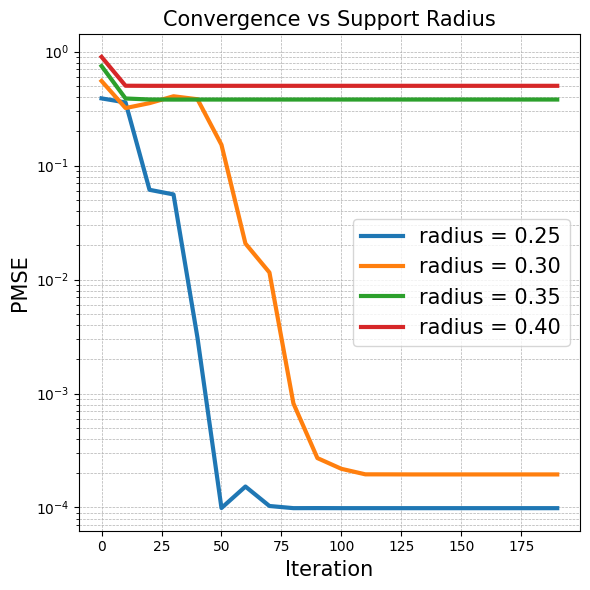

In [85]:
import matplotlib.pyplot as plt

# サンプル間引き間隔（エラーは t=0,10,20,... に保存されている前提）
interval = 10
timesteps = [t * interval for t in range(len(error_log[0]))]

# 描画
plt.figure(figsize=(6, 6))
for i, log in enumerate(error_log):
    plt.plot(timesteps, log, label=f"radius = {support_radious_list[i]:.2f}", lw = 3)

plt.yscale("log")  # y軸を対数スケールに
plt.xlabel("Iteration", fontsize = 15)
plt.ylabel("PMSE", fontsize = 15)
plt.title("Convergence vs Support Radius", fontsize = 15)
plt.legend(fontsize = 15)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


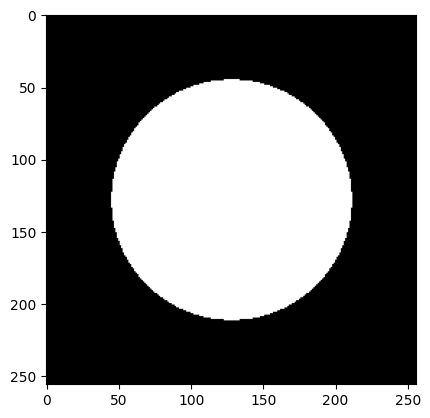

In [66]:
from matplotlib import pyplot as plt
plt.imshow(support, cmap = "gray")

In [4]:
import numpy as np
from gpie import Graph, GaussianPrior, fft2, AmplitudeMeasurement, pmse
from gpie.core.linalg_utils import random_phase_mask
from numpy.typing import NDArray

# ==== 1. パラメータ ====
H, W = 128, 128
shape = (H, W)
rng = np.random.default_rng(seed=42)
n_measurements = 4
phase_masks = [random_phase_mask(shape, rng=rng) for _ in range(n_measurements)]

class CodedDiffractionPattern(Graph):
    def __init__(self, noise : np.float64, n_measurements : int, phase_masks : list[NDArray]) -> None :
        super().__init__()
        x = ~GaussianPrior(shape = shape, label = "sample")
        for i in range(n_measurements):
            z = fft2(phase_masks[i] * x)
            with self.observe():
                y = AmplitudeMeasurement(var=noise, damping=0.2) @ z
        self.compile()

# ==== 4. 初期化と推論 ====
g =CodedDiffractionPattern(noise = 1e-4, n_measurements=3, phase_masks = phase_masks)


g.set_init_rng(np.random.default_rng(seed=1))
g.generate_sample(rng=np.random.default_rng(seed=999), update_observed=True)
X = g.get_wave("sample")
true_x = X.get_sample()

def monitor(graph, t):
    x = graph.get_wave("sample").compute_belief().data
    err = pmse(x, true_x)
    if t % 20 == 0:
        print(f"[t={t}] PSE (sum) = {err:.5e}")

g.run(n_iter=200, callback=monitor, verbose = False)

[t=0] PSE (sum) = 1.14529e+00
[t=20] PSE (sum) = 1.00059e+00
[t=40] PSE (sum) = 9.88274e-01
[t=60] PSE (sum) = 9.80744e-01
[t=80] PSE (sum) = 9.76264e-01
[t=100] PSE (sum) = 9.74103e-01
[t=120] PSE (sum) = 9.71081e-01
[t=140] PSE (sum) = 9.53473e-01
[t=160] PSE (sum) = 9.05781e-02
[t=180] PSE (sum) = 8.52656e-04


In [5]:
g.visualize()

Loading BokehJS ...

In [98]:
class CodedDiffractionPattern(Graph):
    def __init__(self, noise : np.float64, n_measurements : int, phase_masks : list[NDArray]) -> None :
        super().__init__()
        x = ~GaussianPrior(shape = shape, label = "sample")
        for i in range(n_measurements):
            z = fft2(phase_masks[i] * x)
            with self.observe():
                y = AmplitudeMeasurement(var=noise, damping=0.2) @ z
        self.compile()

error_log = [[] for i in range (4)]
measurement_numbers = [2,3,4,5]

for i in range(4):
    n = measurement_numbers[i]
    H, W = 128, 128
    shape = (H, W)
    rng = np.random.default_rng(seed=42)
    n_measurements = n
    phase_masks = [random_phase_mask(shape, rng=rng) for _ in range(n_measurements)]
    g =CodedDiffractionPattern(noise = 1e-4, n_measurements=n, phase_masks = phase_masks)
    
    g.set_init_rng(np.random.default_rng(seed=1))
    g.generate_sample(rng=np.random.default_rng(seed=999), update_observed=True)
    X = g.get_wave("sample")
    true_x = X.get_sample()

    def monitor(graph, t):
        X = graph.get_wave("sample")
        est = X.compute_belief().data
        err = pmse(est, true_x)
        if t % 10 == 0:
            error_log[i].append(err)
    
    g.run(n_iter=200, callback=monitor, verbose = False)

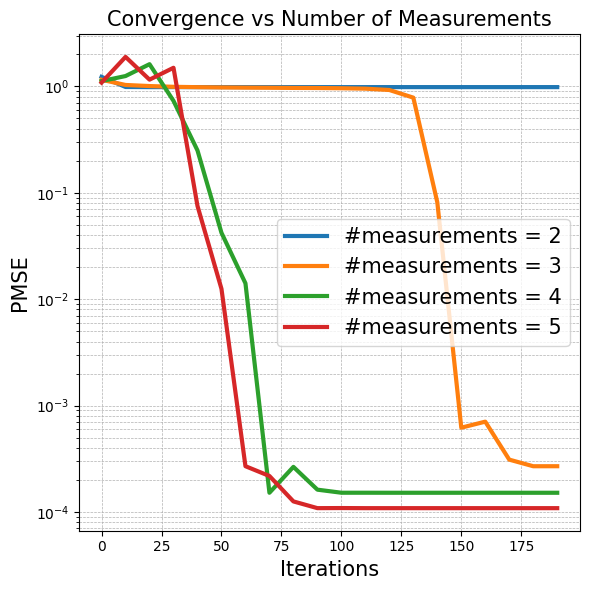

In [102]:
import matplotlib.pyplot as plt

# 各ログの記録タイミング（t = 0, 10, ..., 200）
interval = 10
timesteps = [t * interval for t in range(len(error_log[0]))]

# 測定数（凡例用）
measurement_counts = [2, 3, 4, 5]

# プロット
plt.figure(figsize=(6, 6))
for i, log in enumerate(error_log):
    plt.plot(timesteps, log, label=f"#measurements = {measurement_counts[i]}", lw = 3)

plt.yscale("log")  # y軸を対数スケールに
plt.xlabel("Iterations", fontsize = 15)
plt.ylabel("PMSE", fontsize = 15)
plt.title("Convergence vs Number of Measurements", fontsize = 15)
plt.legend(fontsize = 15)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
